In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [3]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [4]:
immune_classes = pd.read_csv(os.getcwd()+'/data/immune_classes.txt', sep = '\t')
immune_classes.rename(columns = {'Unnamed: 0':'t_ind'}, inplace = True)

In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [6]:

covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data = covid_data[covid_data['location']=='World']
covid_data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
384403,OWID_WRL,NaN,World,2020-01-05,2.0,2.0,NaN,3.0,3.0,NaN,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
384404,OWID_WRL,NaN,World,2020-01-06,2.0,0.0,NaN,3.0,0.0,NaN,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
384405,OWID_WRL,NaN,World,2020-01-07,2.0,0.0,NaN,3.0,0.0,NaN,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
384406,OWID_WRL,NaN,World,2020-01-08,2.0,0.0,NaN,3.0,0.0,NaN,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
384407,OWID_WRL,NaN,World,2020-01-09,2.0,0.0,NaN,3.0,0.0,NaN,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385957,OWID_WRL,NaN,World,2024-04-07,NaN,NaN,NaN,NaN,NaN,NaN,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
385958,OWID_WRL,NaN,World,2024-04-08,NaN,NaN,NaN,NaN,NaN,NaN,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
385959,OWID_WRL,NaN,World,2024-04-09,NaN,NaN,NaN,NaN,NaN,NaN,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
385960,OWID_WRL,NaN,World,2024-04-10,NaN,NaN,NaN,NaN,NaN,NaN,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN


In [7]:
immune_classes.columns

Index(['t_ind', 'date', 'WT', 'B.1', 'B1.1', 'B.1.177', 'B.1.2', 'B.1.1',
       'B.1.3', 'B.1.617.2', 'B.1.1.7', 'B.1.1.7.1', 'BA', 'P.1', 'BA.1',
       'BA.2', 'BA.2.12.1', 'BA.2.12.1.1', 'B.1.617.2.1', 'BA.1.1',
       'B.1.617.2.2', 'BA.4', 'B.1.617.2.3', 'BA.1.1.1', 'BA.5', 'BA.4.6',
       'BM.1.1', 'BA.2.86', 'B.1.617.2.4', 'BN.1', 'XBB', 'BA.5.1', 'JN.1',
       'JN.1.2', 'BQ.1', 'BF.7', 'BQ.1.1', 'XBB.1.5', 'BF.7.1', 'XBB.1.5.1',
       'XBB.1.9', 'XBB.1.16', 'XBB.2.3', 'EG.5.1', 'XBB.1.16.1', 'HK.3',
       'EG.5.1.1', 'HV.1', 'HK.3.1', 'EG.5.1.2', 'HV.1.1', 'HV.1.2',
       'EG.5.1.3', 'XBB.1.16.2', 'JN.1.3', 'HV.1.3', 'JN.1.5', 'JN.1.1',
       'JN.1.4', 'JN.1.6', 'JN.1.4.1', 'JD.1.1', 'JD.1.1.1', 'JD.1.1.2', 'vac',
       'bst', 'biv', 'bst_xbb', 'naive', 'cases'],
      dtype='object')

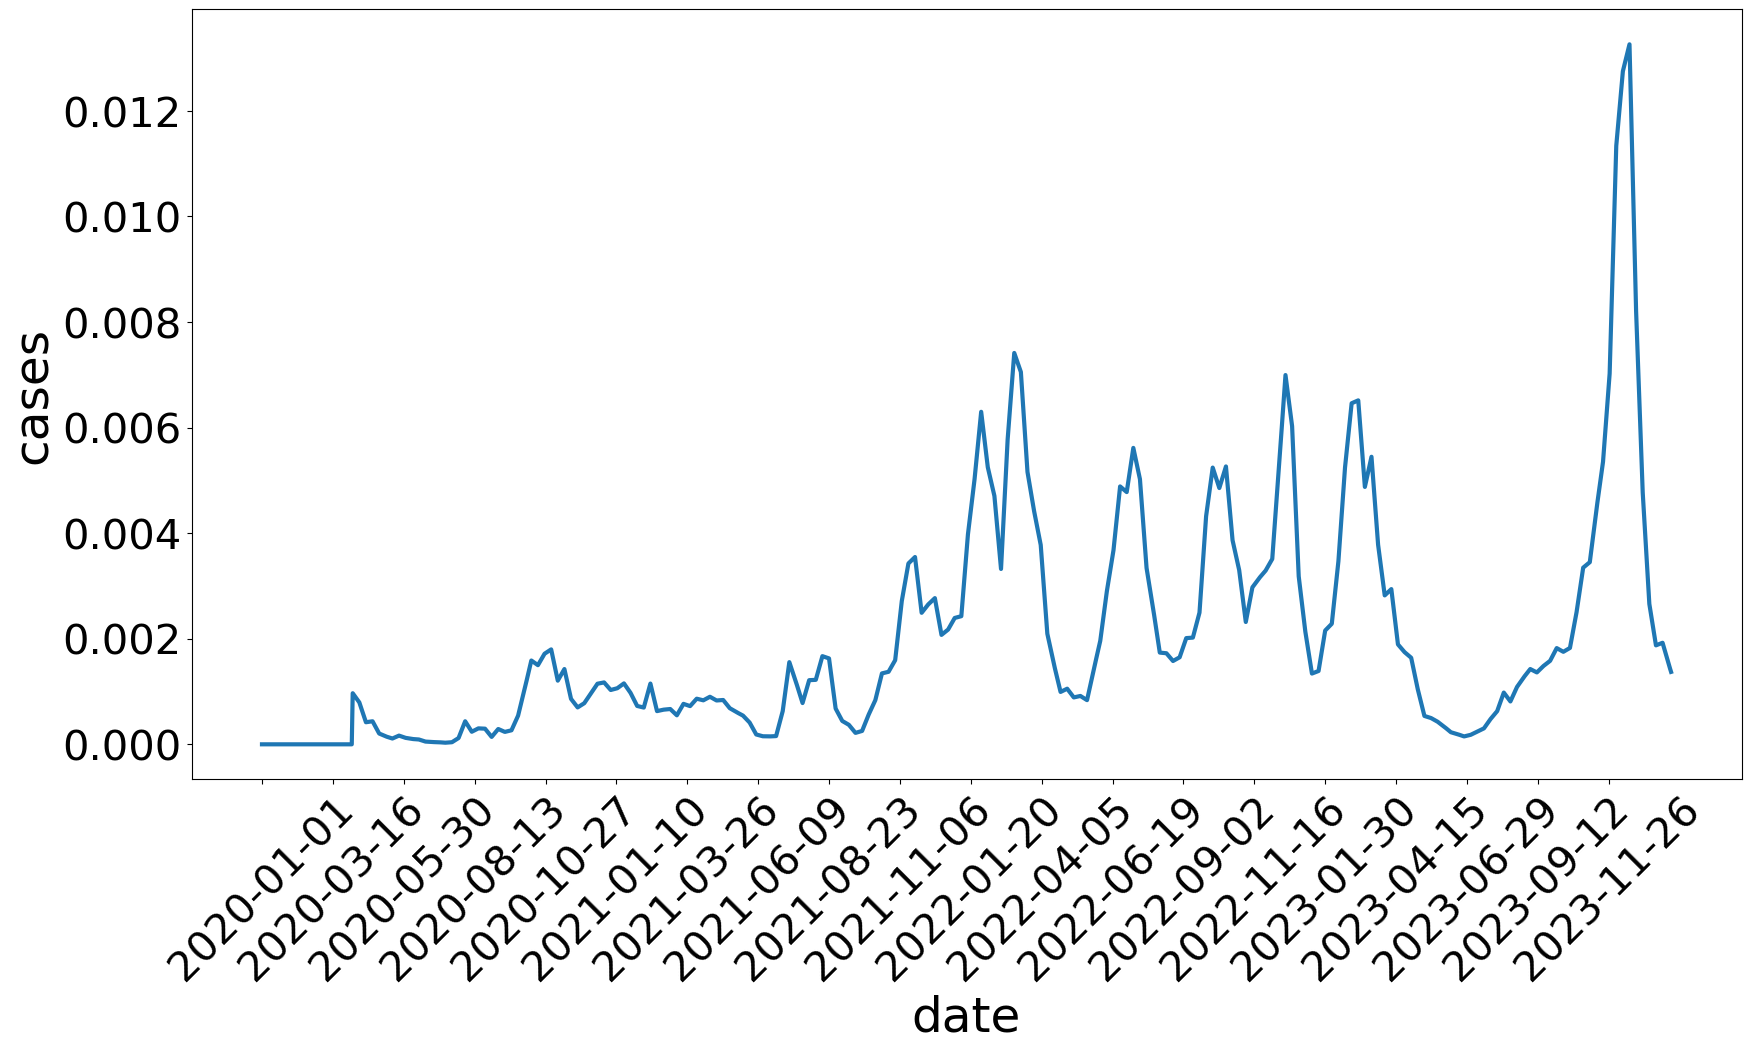

In [8]:
import matplotlib.ticker as ticker
from datetime import date

fig,ax= plt.subplots(1,1,figsize=(20,10))
sns.lineplot(data = immune_classes, x = 'date', y = 'cases', ax = ax)

#reduce tick density and keep date format
printevery_xtick = 75
ax.set_xticks(ax.get_xticks()[::printevery_xtick]);
ax.set_xticklabels(immune_classes['date'][::printevery_xtick], rotation = 45);

In [9]:
covid_data['y_t'] = covid_data['new_cases']/7.8e9
covid_data['y_t_smoothed'] = covid_data['new_cases_smoothed']/7.8e8

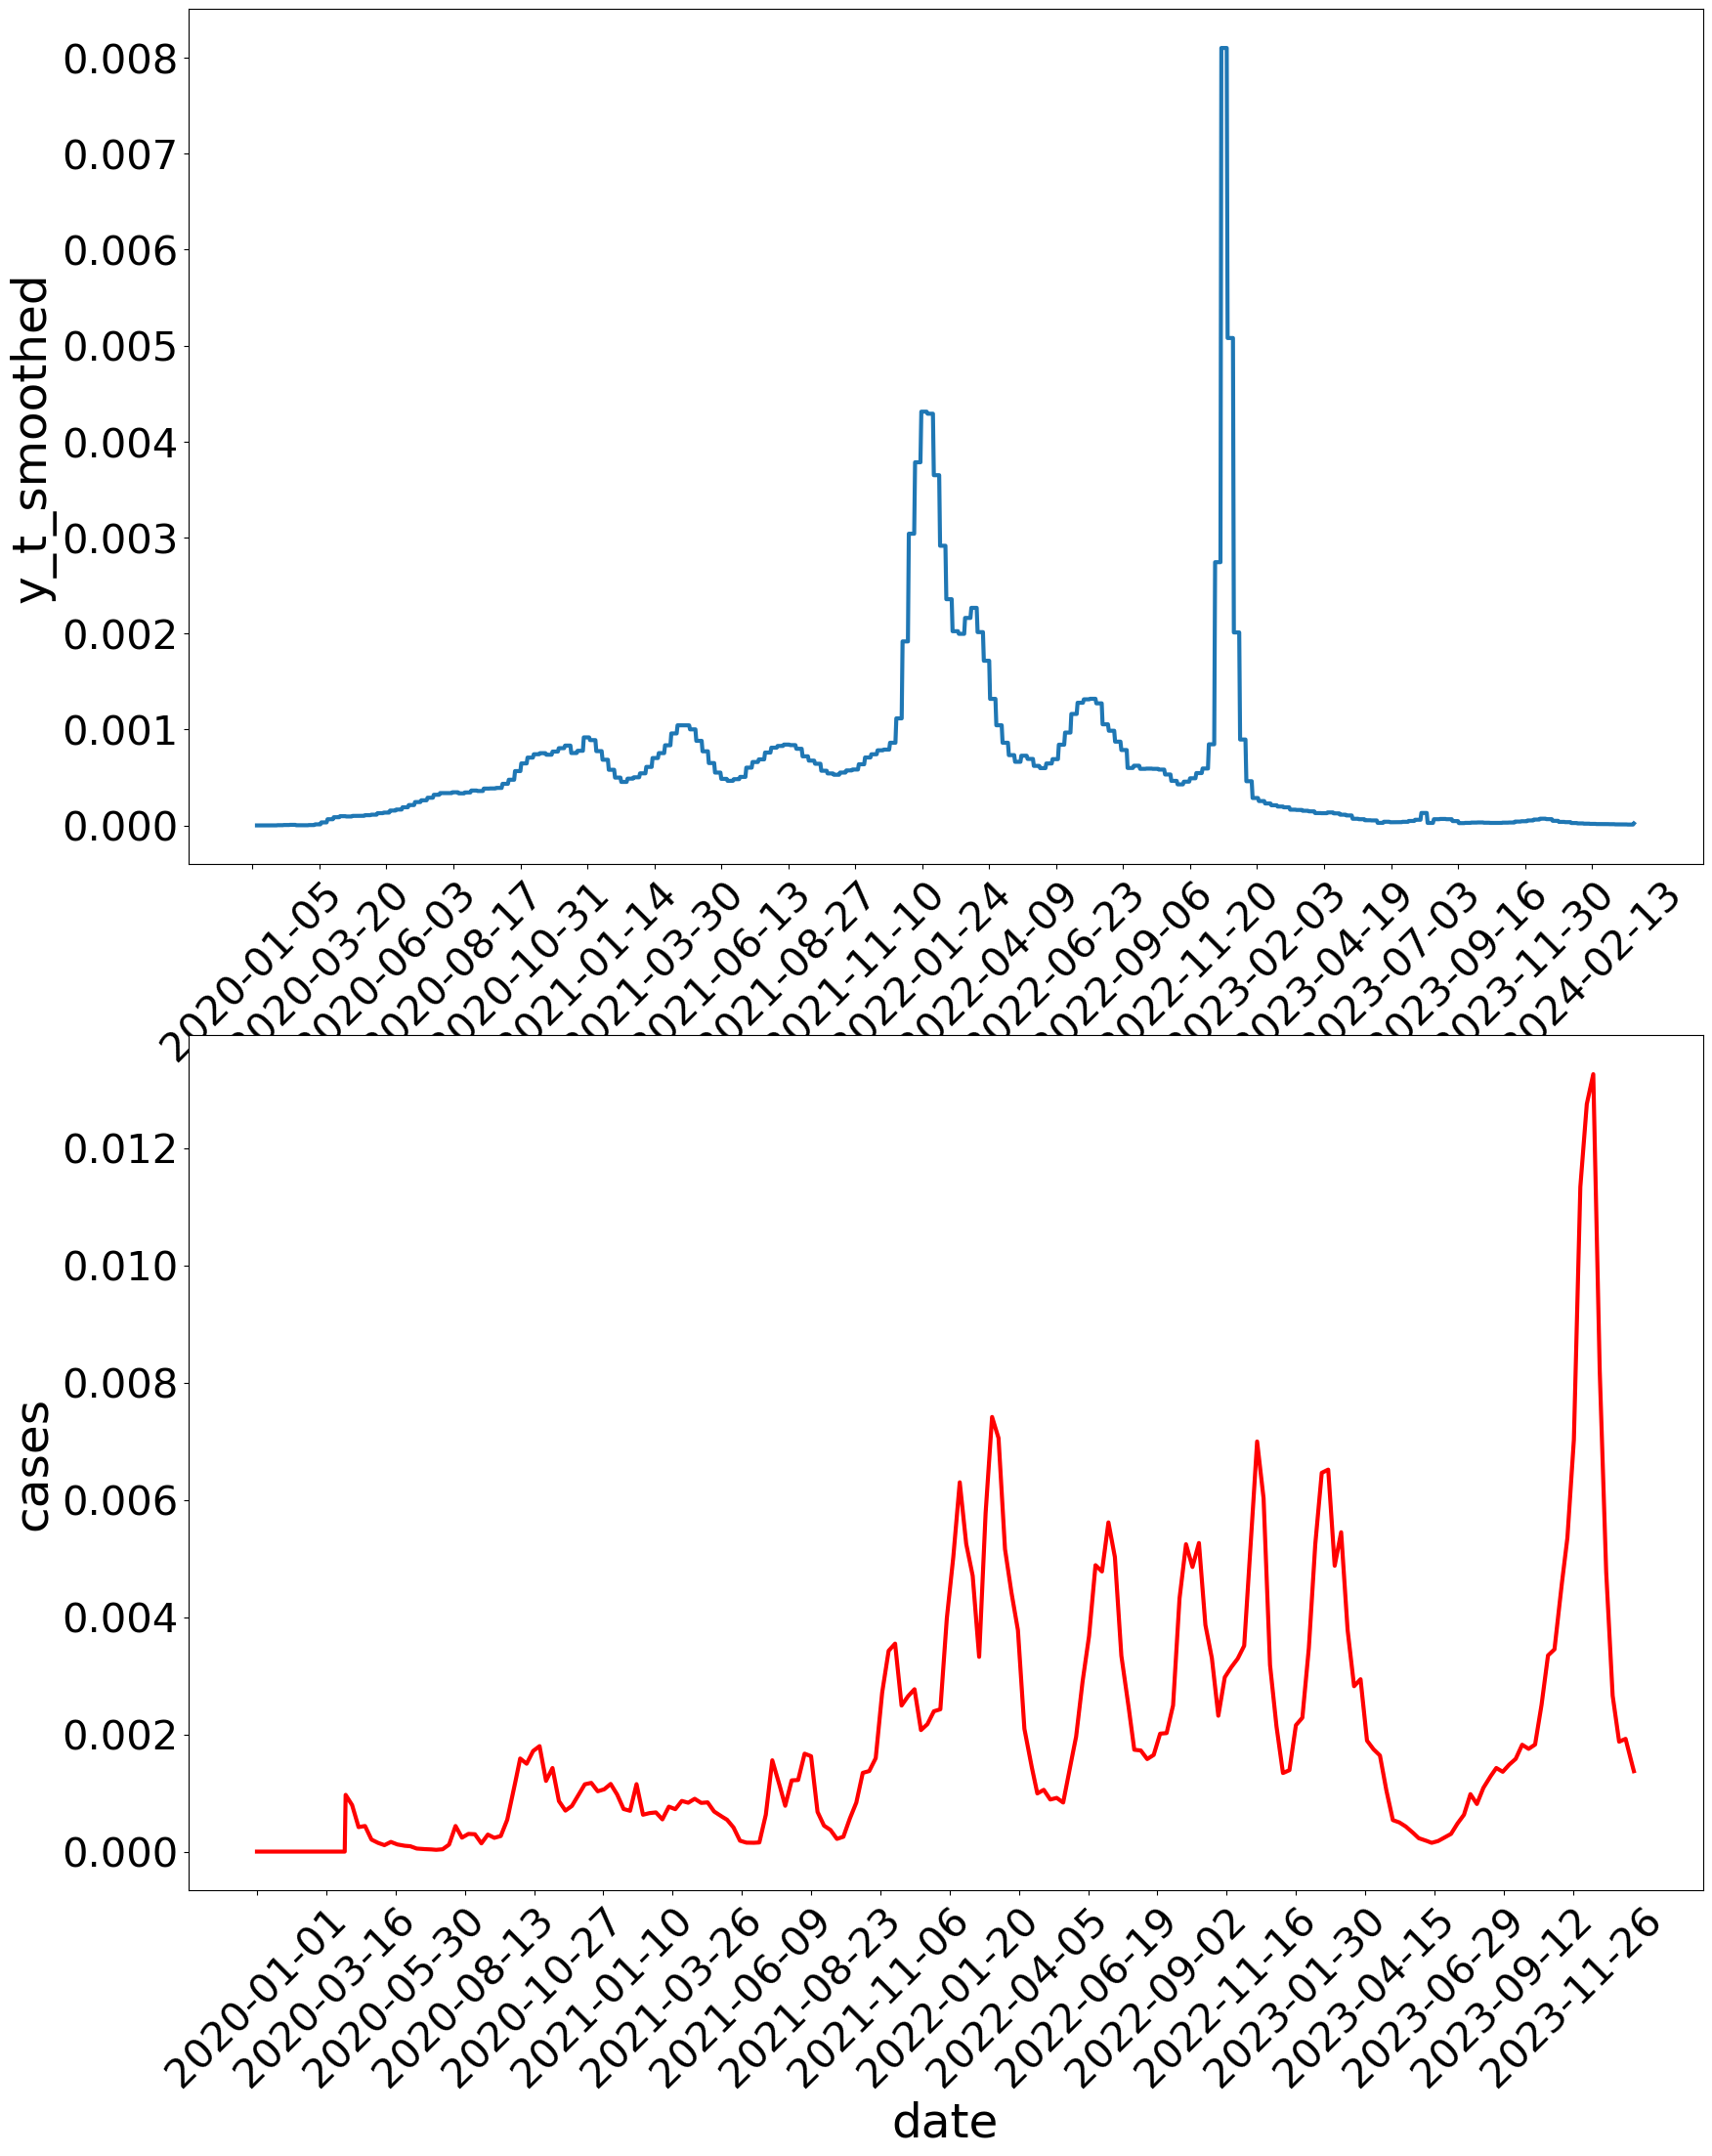

In [10]:
fig,ax= plt.subplots(2,1,figsize=(20,25))
sns.lineplot(data = covid_data, x = 'date', y = 'y_t_smoothed', ax = ax[0])
sns.lineplot(data = immune_classes, x = 'date', y = 'cases', ax = ax[1], color = 'red')

ax_to_data = {ax[0]:covid_data, ax[1]:immune_classes}

#reduce tick density and keep date format
printevery_xtick = 75
for a in ax:
    a.set_xticks(a.get_xticks()[::printevery_xtick]);
    a.set_xticklabels(ax_to_data[a]['date'][::printevery_xtick], rotation = 45);

In [11]:
immune_classes.columns

Index(['t_ind', 'date', 'WT', 'B.1', 'B1.1', 'B.1.177', 'B.1.2', 'B.1.1',
       'B.1.3', 'B.1.617.2', 'B.1.1.7', 'B.1.1.7.1', 'BA', 'P.1', 'BA.1',
       'BA.2', 'BA.2.12.1', 'BA.2.12.1.1', 'B.1.617.2.1', 'BA.1.1',
       'B.1.617.2.2', 'BA.4', 'B.1.617.2.3', 'BA.1.1.1', 'BA.5', 'BA.4.6',
       'BM.1.1', 'BA.2.86', 'B.1.617.2.4', 'BN.1', 'XBB', 'BA.5.1', 'JN.1',
       'JN.1.2', 'BQ.1', 'BF.7', 'BQ.1.1', 'XBB.1.5', 'BF.7.1', 'XBB.1.5.1',
       'XBB.1.9', 'XBB.1.16', 'XBB.2.3', 'EG.5.1', 'XBB.1.16.1', 'HK.3',
       'EG.5.1.1', 'HV.1', 'HK.3.1', 'EG.5.1.2', 'HV.1.1', 'HV.1.2',
       'EG.5.1.3', 'XBB.1.16.2', 'JN.1.3', 'HV.1.3', 'JN.1.5', 'JN.1.1',
       'JN.1.4', 'JN.1.6', 'JN.1.4.1', 'JD.1.1', 'JD.1.1.1', 'JD.1.1.2', 'vac',
       'bst', 'biv', 'bst_xbb', 'naive', 'cases'],
      dtype='object')

In [12]:
immune_classes.columns[2:-6]

Index(['WT', 'B.1', 'B1.1', 'B.1.177', 'B.1.2', 'B.1.1', 'B.1.3', 'B.1.617.2',
       'B.1.1.7', 'B.1.1.7.1', 'BA', 'P.1', 'BA.1', 'BA.2', 'BA.2.12.1',
       'BA.2.12.1.1', 'B.1.617.2.1', 'BA.1.1', 'B.1.617.2.2', 'BA.4',
       'B.1.617.2.3', 'BA.1.1.1', 'BA.5', 'BA.4.6', 'BM.1.1', 'BA.2.86',
       'B.1.617.2.4', 'BN.1', 'XBB', 'BA.5.1', 'JN.1', 'JN.1.2', 'BQ.1',
       'BF.7', 'BQ.1.1', 'XBB.1.5', 'BF.7.1', 'XBB.1.5.1', 'XBB.1.9',
       'XBB.1.16', 'XBB.2.3', 'EG.5.1', 'XBB.1.16.1', 'HK.3', 'EG.5.1.1',
       'HV.1', 'HK.3.1', 'EG.5.1.2', 'HV.1.1', 'HV.1.2', 'EG.5.1.3',
       'XBB.1.16.2', 'JN.1.3', 'HV.1.3', 'JN.1.5', 'JN.1.1', 'JN.1.4',
       'JN.1.6', 'JN.1.4.1', 'JD.1.1', 'JD.1.1.1', 'JD.1.1.2'],
      dtype='object')

NameError: name 'omicron_origination' is not defined

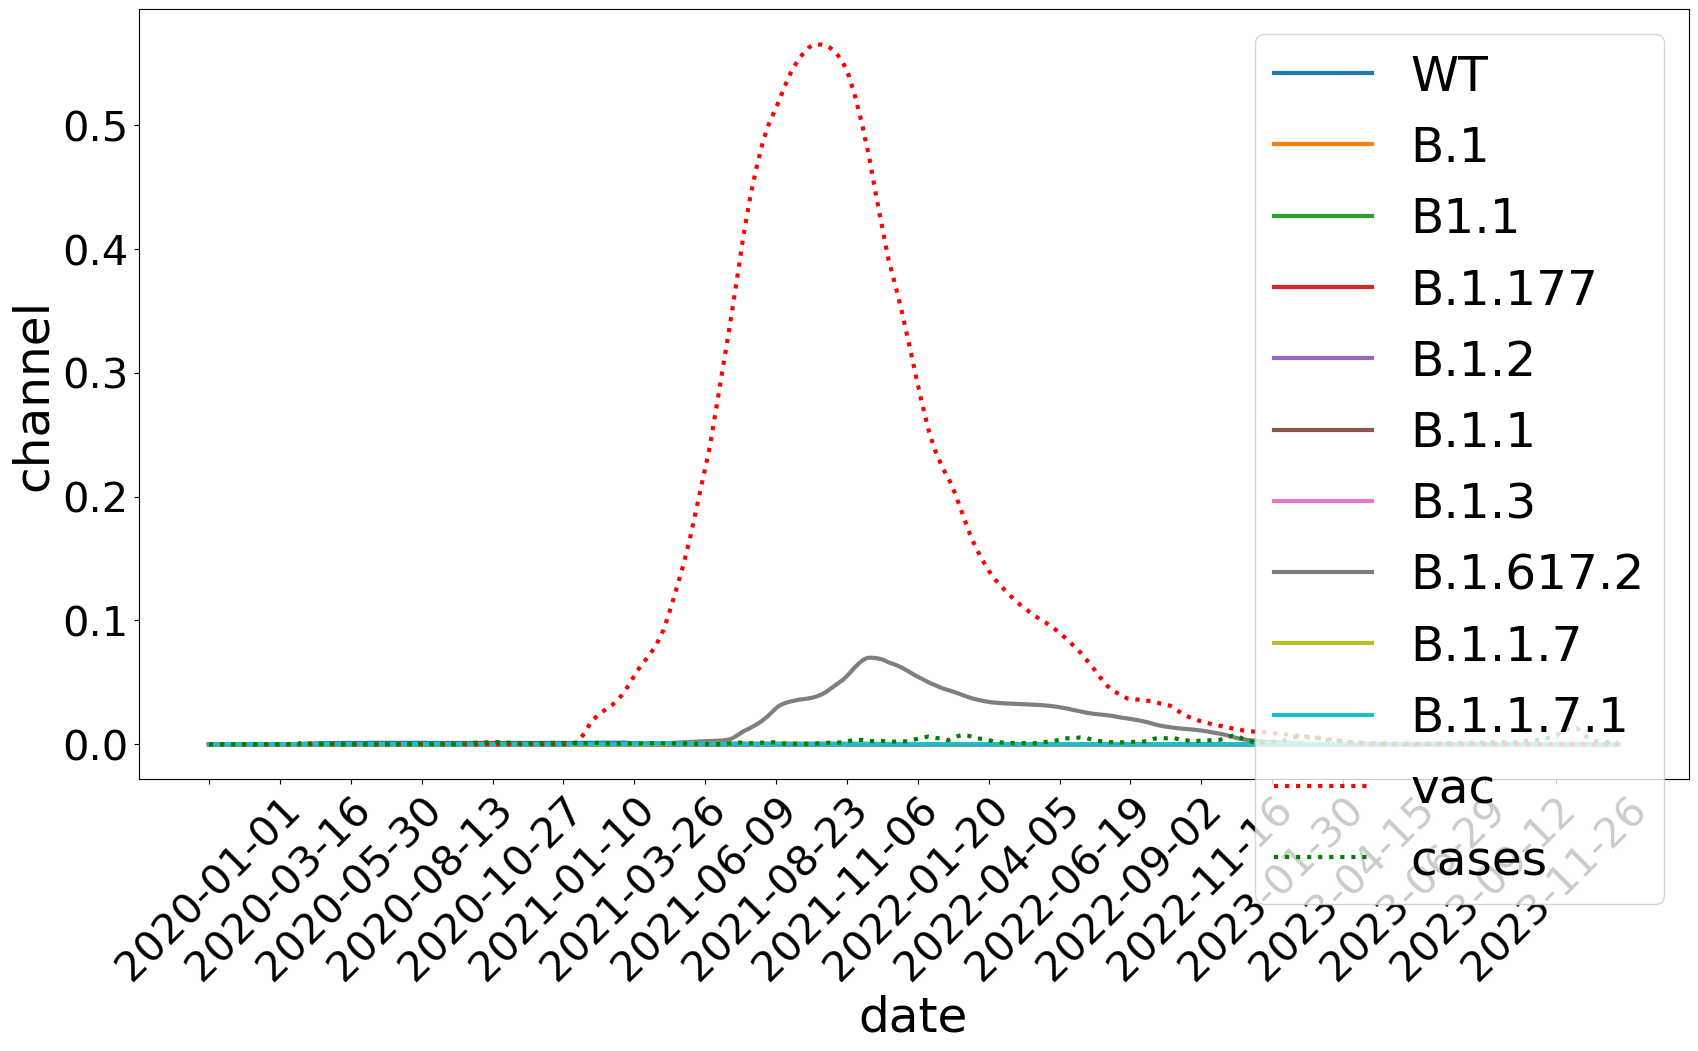

In [13]:
fig,ax= plt.subplots(1,1,figsize=(20,10))

for c in immune_classes.columns[2:12]:
    sns.lineplot(data = immune_classes, x = 'date', y = c, ax = ax, label = c)
sns.lineplot(data = immune_classes, x = 'date', y = 'vac', ax = ax, label = 'vac',color='red',ls=':')
sns.lineplot(data = immune_classes, x = 'date', y = 'cases', ax = ax, label = 'cases',color='green',ls=':')
ax.legend()
ax.set_ylabel('channel')
#reduce tick density and keep date format
printevery_xtick = 75
ax.set_xticks(ax.get_xticks()[::printevery_xtick]);
ax.set_xticklabels(immune_classes['date'][::printevery_xtick], rotation = 45);
ax.axvline(x = omicron_origination,color='r')
ax.set_yscale('log')

In [ ]:
import datetime as dt

In [ ]:
immune_classes = pd.read_csv(os.getcwd()+'/data/immune_classes.txt', sep = '\t')
immune_classes.rename(columns = {'Unnamed: 0':'t_ind'}, inplace = True)

In [ ]:
# immune_classes['date'] = immune_classes['date'].apply(pd.Timestamp)
# immune_classes = immune_classes.set_index('date')

# covid_data['date'] = covid_data['date'].apply(pd.Timestamp)
# covid_data = covid_data.set_index('date')


In [ ]:
ax.get_xticks()[::printevery_xtick],immune_classes['date'][::printevery_xtick]


(array([0]),
 0       2020-01-01
 75      2020-03-16
 150     2020-05-30
 225     2020-08-13
 300     2020-10-27
 375     2021-01-10
 450     2021-03-26
 525     2021-06-09
 600     2021-08-23
 675     2021-11-06
 750     2022-01-20
 825     2022-04-05
 900     2022-06-19
 975     2022-09-02
 1050    2022-11-16
 1125    2023-01-30
 1200    2023-04-15
 1275    2023-06-29
 1350    2023-09-12
 1425    2023-11-26
 Name: date, dtype: object)

In [ ]:
immune_classes.columns[9]

'B.1.617.2'

In [ ]:
omicron_origination = immune_classes.query(f'`{immune_classes.columns[9]}` > 0').iloc[0]['date']
omicron_origination

'2021-02-27'

In [ ]:
immune_classes['cumulative_cases'] = immune_classes['cases'].cumsum()

In [ ]:
covid_data['y_t'] = covid_data['new_cases']/7.8e9
covid_data['y_t_smoothed'] = covid_data['new_cases_smoothed']/7.8e9
covid_data['z_t'] = covid_data['y_t_smoothed'].cumsum()
covid_data['v_t'] = covid_data['people_vaccinated']/7.8e9
covid_data['v_t'][np.isnan(covid_data['v_t'])]=0

covid_data['imm']= covid_data['v_t'] + covid_data['z_t']
covid_data['pi_z_p_v_t_y']= covid_data['imm']*covid_data['y_t_smoothed']
covid_data['pi_z_t_y']= covid_data['z_t']*covid_data['y_t_smoothed']


/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_1595/2598384493.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  covid_data['v_t'][np.isnan(covid_data['v_t'])]=0
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_1595/2

In [ ]:
immune_classes['pi_z_p_v_t_y'] = (immune_classes['vac']+(immune_classes['WT']+ immune_classes['B.1.177']))*immune_classes['cases']
immune_classes['pi_z_t_y'] = (immune_classes['WT']+ immune_classes['B.1.177'])*immune_classes['cases']

(0.0, 1e-05)

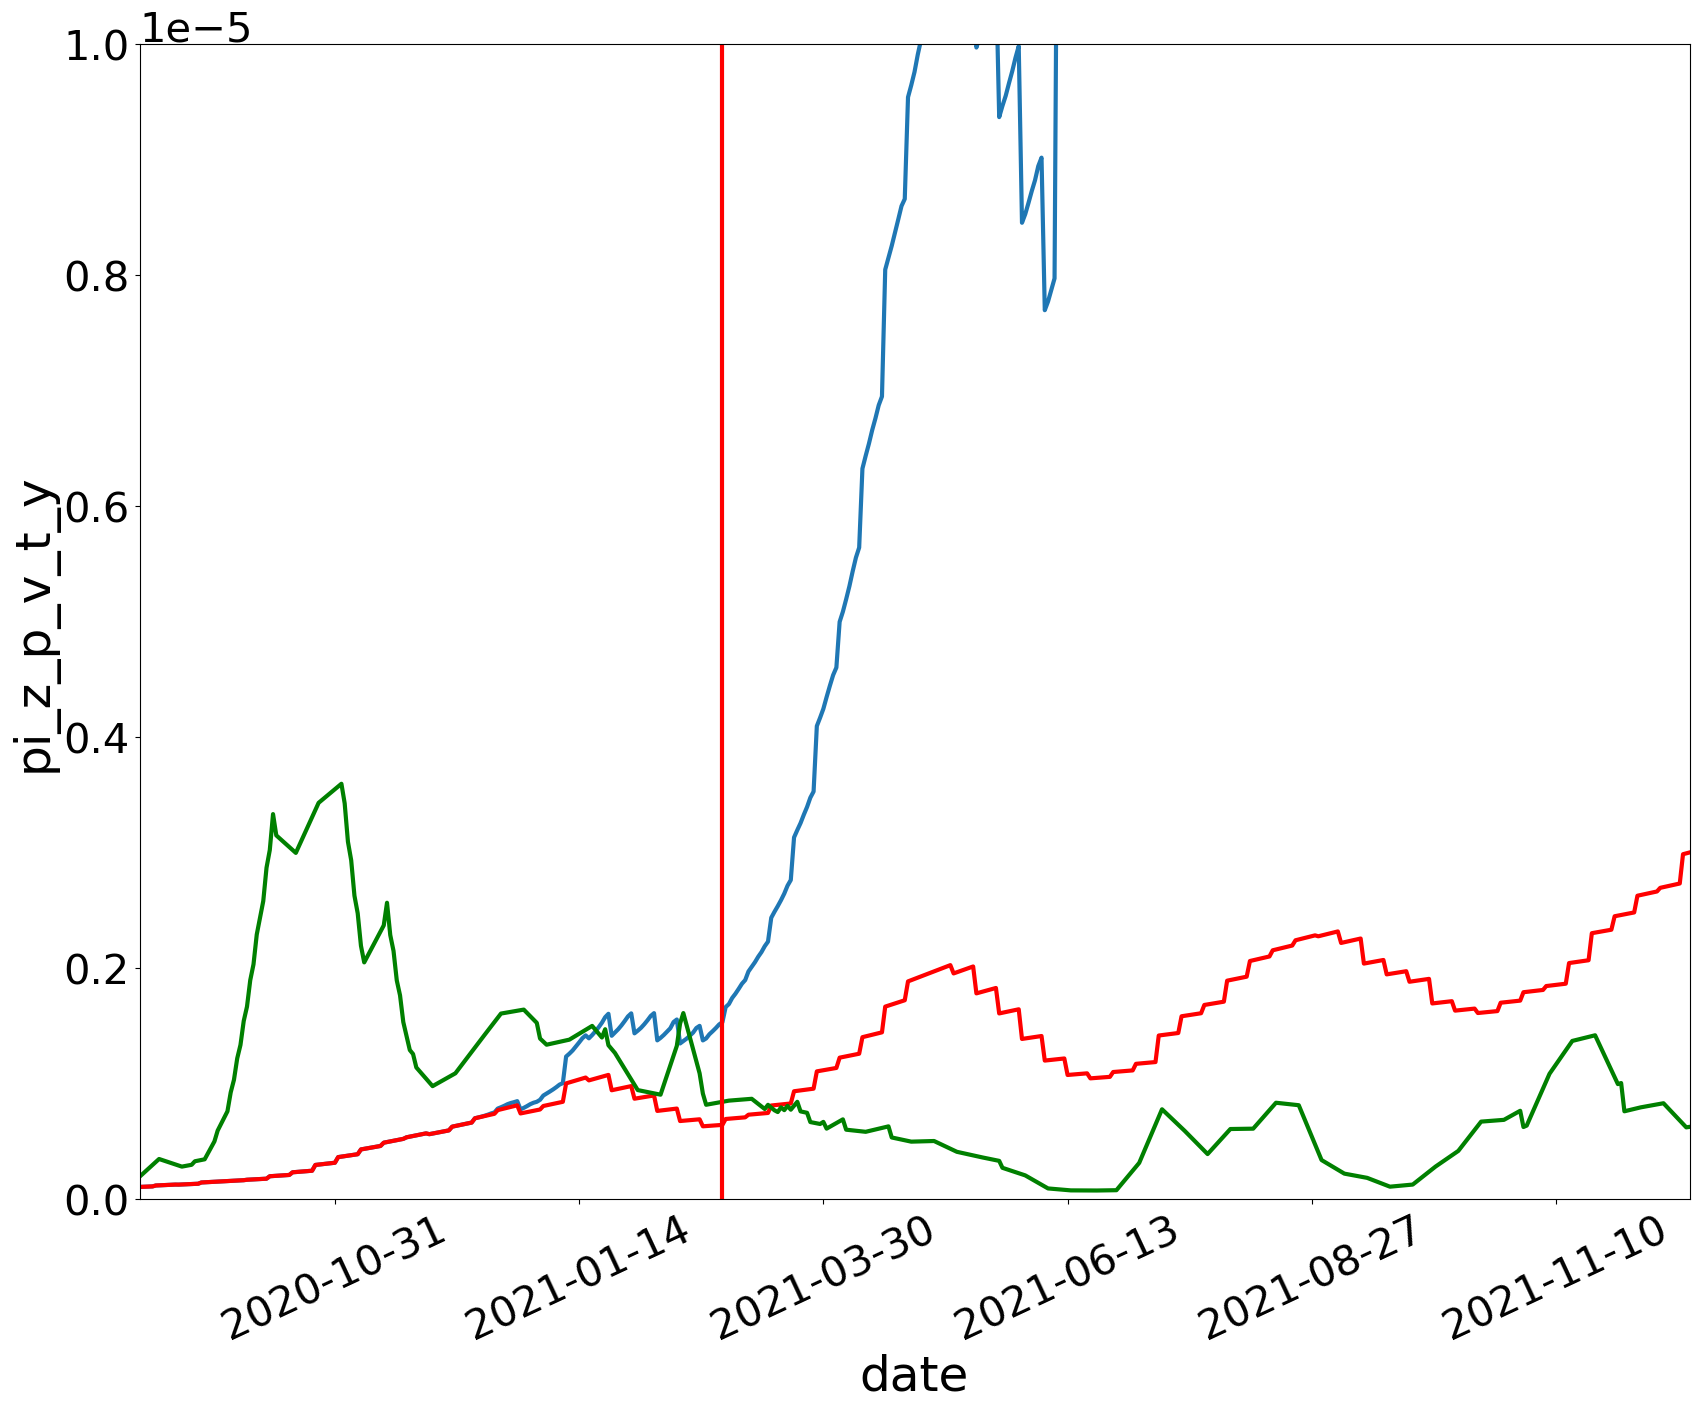

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(20,15))
# sns.lineplot(data = covid_data, x = 'date', y = 'z_t', ax = ax)
# sns.lineplot(data = covid_data, x = 'date', y = 'v_t', ax = ax)
sns.lineplot(data = covid_data, x = 'date', y = 'pi_z_p_v_t_y', ax = ax)
sns.lineplot(data = covid_data, x = 'date', y = 'pi_z_t_y', ax = ax, color='red')
sns.lineplot(data = immune_classes, x = 'date', y = 'pi_z_t_y', ax = ax, color = 'green')

# sns.lineplot(data = immune_classes, x = 'date', y = 'cumulative_cases', ax = ax, color = 'red')
printevery_xtick = 75

ax.set_xticks(ax.get_xticks()[::printevery_xtick]);
ax.set_xticklabels(covid_data['date'][::printevery_xtick], rotation = 25);
ax.axvline(x = omicron_origination,color='r')
                            # ),color='r')

# ax.set_yscale('log')
ax.set_xlim(left = '2020-09-01',right = '2021-12-21')
ax.set_ylim(bottom=0,top = 1e-5)

# tax= ax.twinx()
# sns.lineplot(data = immune_classes, x = 'date', y = 'vac', ax = tax, color = 'green')

In [ ]:
covid_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [15]:
covid_data_full = pd.read_csv(os.getcwd()+'/data/covid_data.csv')

In [16]:
covid_data_full['location'].unique()
covid_data_full.query('location == "Germany"')['population'].unique()


array([83369840.])

In [17]:
covid_data_full['y_t_country'] = covid_data_full['new_cases_smoothed']/covid_data_full['population']

covid_data_full['weekly_y_t_country'] = covid_data_full['y_t_country']*7

In [18]:
covid_data_full['weekly_new_cases_smoothed'] = covid_data_full['new_cases_smoothed']*7

NameError: name 'omicron_origination' is not defined

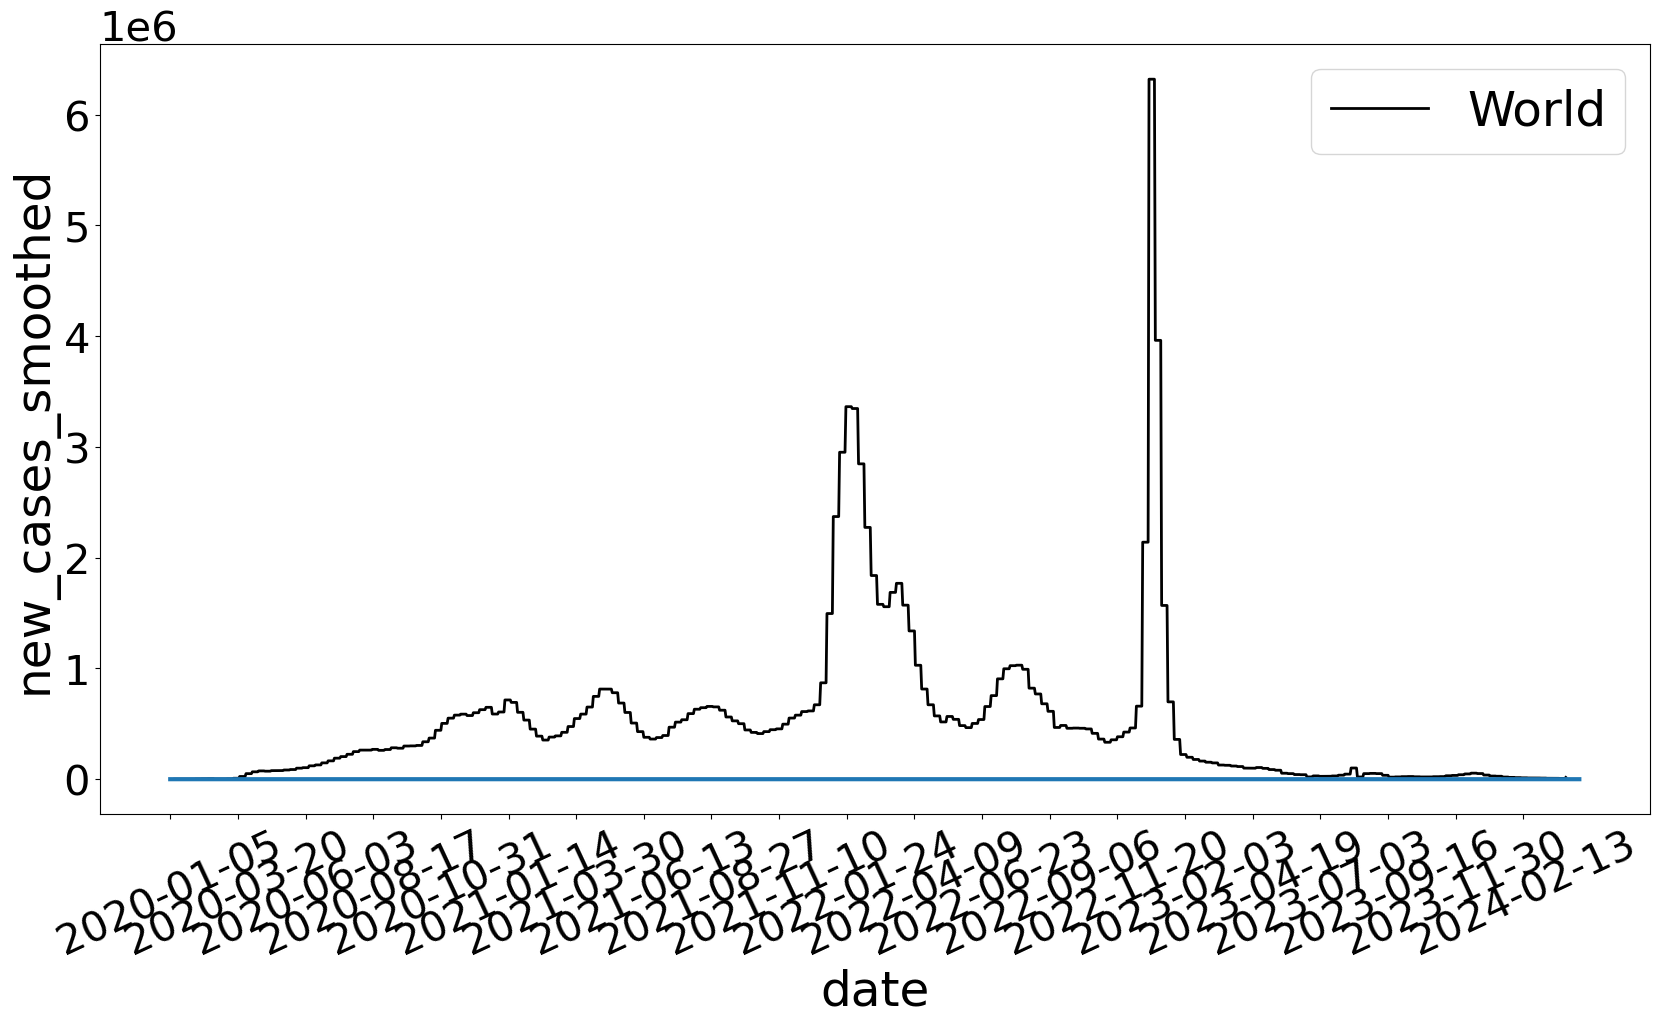

In [19]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
# for country in ['Germany','United States','United Kingdom','France','Italy']:
#     sns.lineplot(data = covid_data_full.query(f'location == "{country}"'), x = 'date', y = 'weekly_y_t_country', label = country,alpha=0.5)
sns.lineplot(data = covid_data_full.query(f'location == "World"'), x = 'date', y = 'new_cases_smoothed', label = "World",lw=2,color='black')
sns.lineplot(data =immune_classes, x = 'date', y = 'cases')

ax.set_xticks(ax.get_xticks()[::printevery_xtick]);
ax.set_xticklabels(covid_data['date'][::printevery_xtick], rotation = 25);
ax.axvline(x = omicron_origination,color='r')
ax.set_xlim(right = '2022-12-21')
ax.set_ylim(bottom=1e-5,top = 5e-2)
# ax.set_yscale('log')
ax.legend(fontsize = 20)
ax.axhline(1e-2,color='k',ls='--')
ax.axhline(1e-3,color='k',ls='--')

In [20]:
covid_data_full['weekly_dates'] = pd.to_datetime(covid_data_full['date']).dt.isocalendar().week
covid_data_full['weekly_new_cases'] = covid_data_full['new_cases'].rolling(window=7).mean()

(0.0, 8000000.0)

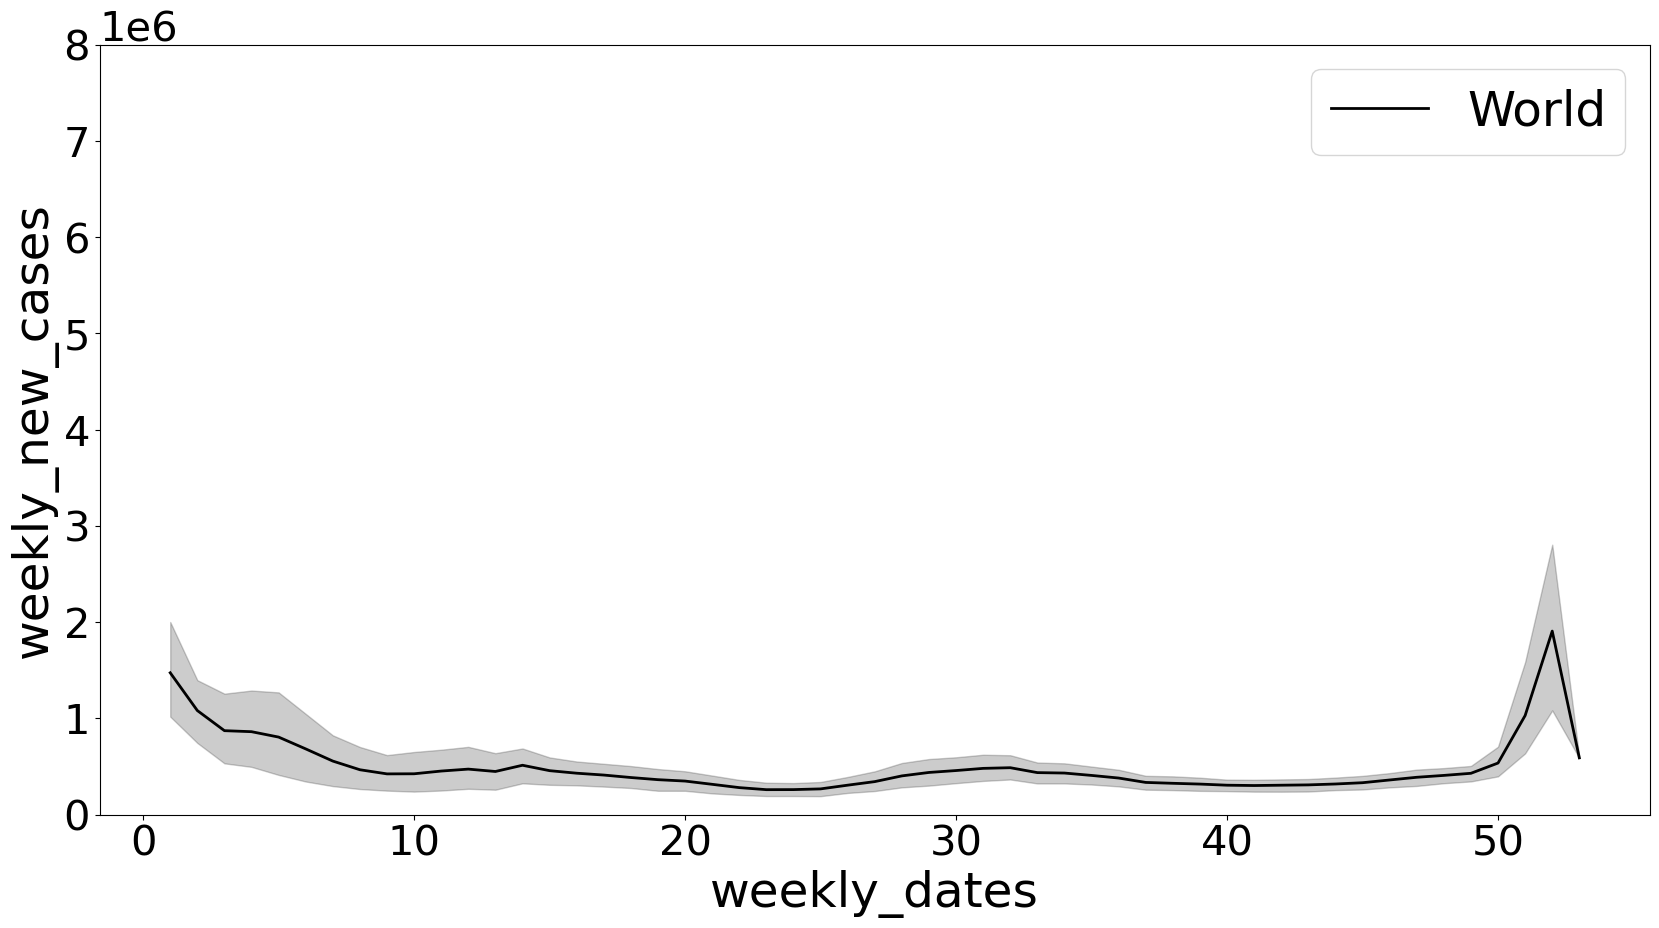

In [21]:
fig,ax= plt.subplots(1,1,figsize=(20,10))
sns.lineplot(data = covid_data_full.query(f'location == "World"'), x = 'weekly_dates', y = 'weekly_new_cases', label = "World",lw=2,color='black')
# sns.lineplot(data =immune_
# classes, x = 'date', y = 'cases')

# ax.set_xticks(ax.get_xticks()[::printevery_xtick]);
# ax.set_xticklabels(covid_data_full['weekly_dates'][::printevery_xtick], rotation = 25);
# ax.set_yscale('log')
ax.set_ylim(bottom=0,top = 8e6)


In [22]:
covid_data_full['date']

0         2020-01-05
1         2020-01-06
2         2020-01-07
3         2020-01-08
4         2020-01-09
             ...    
390601    2024-03-27
390602    2024-03-28
390603    2024-03-29
390604    2024-03-30
390605    2024-03-31
Name: date, Length: 390606, dtype: object

In [ ]:
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = .5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution
R0 = 5
kappa = 1e4
N= 7.8e9
I0 = 1

ts, (S,I) = integrate_trajectory(R0,kappa,N,I0, Nsteps = int(1e6))

x,y = S/N,I/N

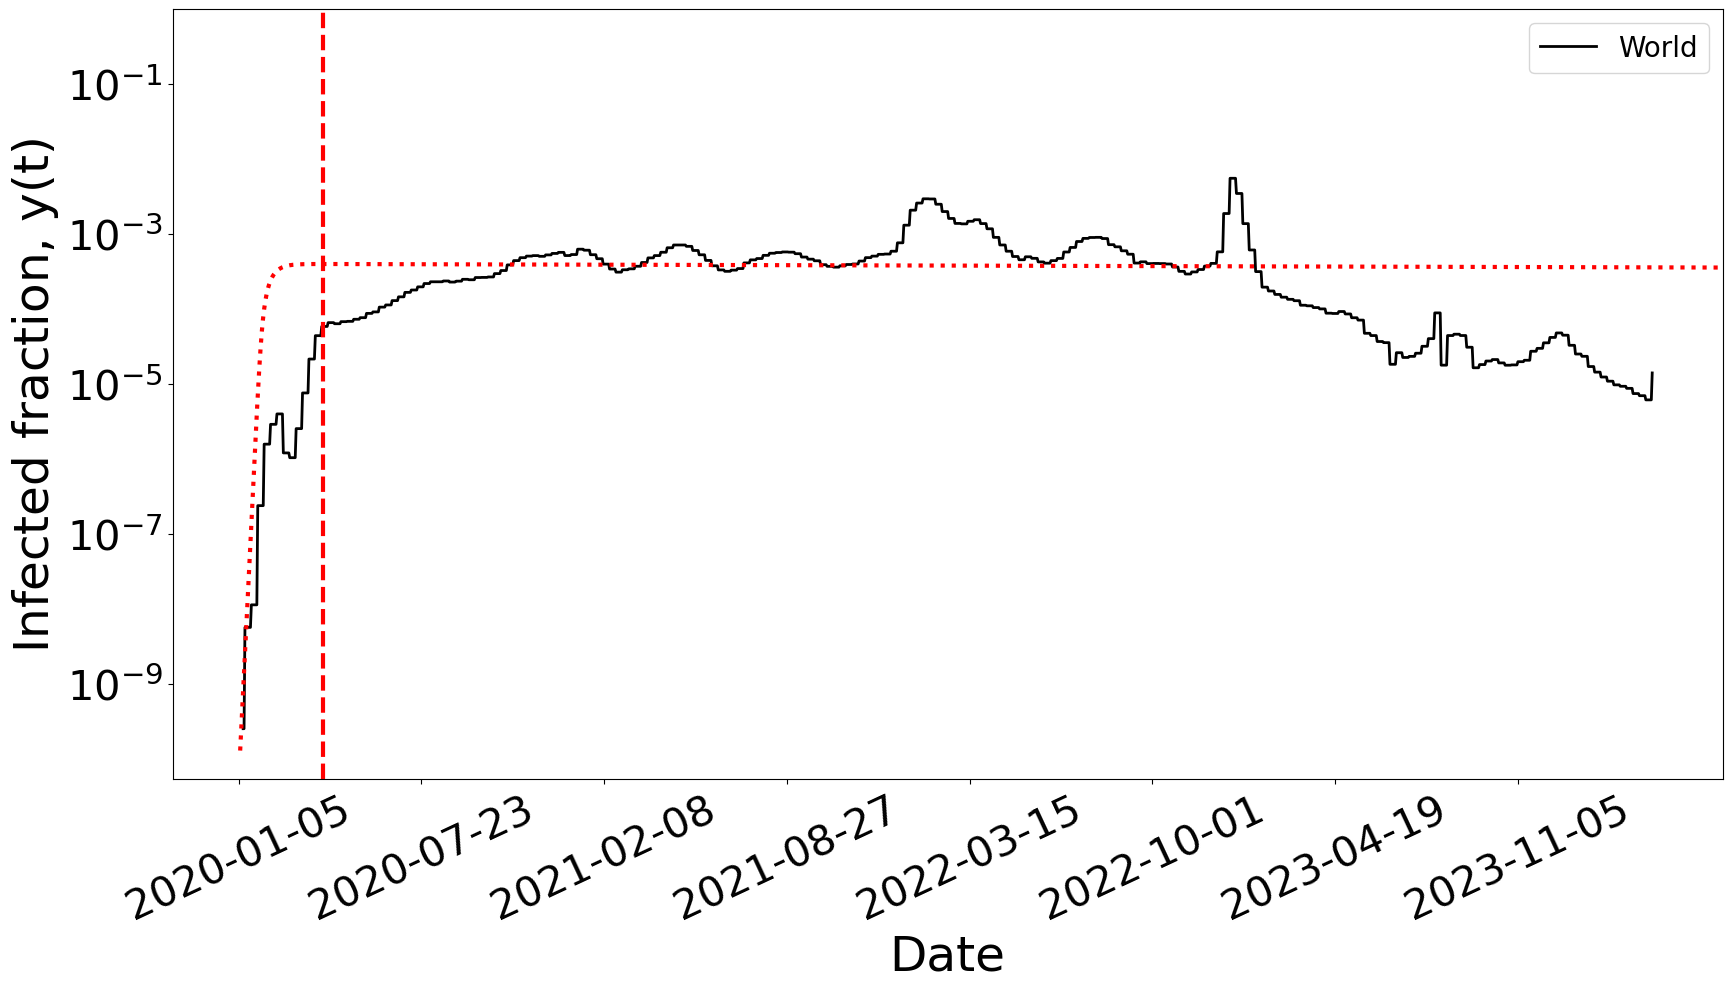

In [98]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
# for country in ['Germany','United States','United Kingdom','France','Italy']:
#     sns.lineplot(data = covid_data_full.query(f'location == "{country}"'), x = 'date', y = 'weekly_y_t_country', label = country,alpha=0.5)
sns.lineplot(data = covid_data_full.query(f'location == "World"'), x = 'date', y = 'weekly_y_t_country', label = "World",lw=2,color='black')

printevery_xtick = 200
ax.set_xticks(ax.get_xticks()[::printevery_xtick]);
ax.set_xticklabels(covid_data['date'][::printevery_xtick], rotation = 25);
# ax.axvline(x = omicron_origination,color='r')
# ax.set_xlim(right = '2022-12-21')

# ax.set_yscale('log')
ax.legend(fontsize = 20)
# ax.axhline(1e-2,color='k',ls='--')
# ax.axhline(1e-3,color='k',ls='--')
# ax.axhline(5.69e6,color='k',ls='--')
# ax.axvline(x = '2021-05-05',color='r')
# delta_ba1_crossover_date = pd.to_datetime('2022-01-03')
# ax.axvline(x = '2022-01-03',color='r',ls = '--')
xlim = ax.get_xlim()
ax.plot((ts+ts[11])*7,y,color='red',ls=':')
ax.set_xlim(xlim)
ax.axvline((ts[np.argmax(y)]+ts[11])*7,color='r',ls='--')

ax.set_xlabel('Date')
ax.set_ylabel('Infected fraction, $y(t)$')
ax.set_yscale('log')
if ax.yaxis.get_scale() != 'log':
    ax.set_ylim(bottom=-1e-4,top=1e-3)
ax.set_ylim(top=1)
# ax.set_xlim(right = '2023-01-01')
savefig= False
if savefig:
    plt.savefig(output_folder+ ax.yaxis.get_scale()+'prevalence_tser.svg',bbox_inches='tight')

In [96]:
(ts[np.argmax(y)]+ts[11])

13.212550524268188

In [82]:
y0 = 794
y1 = 468

794-(y0-y1)*.4

663.6

In [83]:
clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/clade_stats_SARS-CoV-2'
epi_clade_stats_H3N2 = os.getcwd()+'/data/epi_clade_stats_H3N2'

assert os.path.exists(clade_stats_SARS_CoV_2_folder)
assert os.path.exists(epi_clade_stats_H3N2)

AssertionError: 

In [ ]:
clade_statistics_SARS_CoV_2 = pd.read_csv(clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')

In [ ]:
reference_date = pd.to_datetime('2020-01-01')

In [ ]:
origination_times = clade_statistics_SARS_CoV_2.groupby('Clade')['Time'].min().reset_index()

origination_times['Time_datetime'] = pd.to_datetime(origination_times['Time'])
origination_times['day_diff'] = origination_times['Time_datetime']-origination_times['Time_datetime'].min()
covid_data['Time_datetime'] = pd.to_datetime(covid_data['date'])
covid_data['day_diff'] = covid_data['Time_datetime']-reference_date

covid_data['Time_datatime'].min(), origination_times['Time_datetime'].min()

(Timestamp('2020-01-05 00:00:00'), Timestamp('2019-11-30 00:00:00'))

In [ ]:
x_origination_times = []
xmin_vals =[0]+ list(np.logspace(-7,-1,10))
for xmin in tqdm(xmin_vals ):
    x_mini_df  = clade_statistics_SARS_CoV_2.query(f'Sublineage_Freq > {xmin}').groupby(['Clade'])['Time'].min()
    x_origination_times.append(x_mini_df)

#concatenate with column names time_xmin
x_origination_times = pd.concat(x_origination_times,axis=1)
x_origination_times.columns = [f'time_{xmin:.1e}' for xmin in xmin_vals]



100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


In [ ]:
x_origination_times.reset_index(inplace=True)

for xmin in xmin_vals:
    x_origination_times[f'Time_datetime_{xmin:.1e}'] = pd.to_datetime(x_origination_times[f'time_{xmin:.1e}'])
    x_origination_times[f'day_diff_{xmin:.1e}'] = x_origination_times[f'Time_datetime_{xmin:.1e}']-origination_times['Time_datetime'].min()


In [ ]:
count_thresh = []
for xmin in xmin_vals:
    dcol = x_origination_times[f'day_diff_{xmin:.1e}']
    print(xmin, dcol[~np.isnan(dcol)].count())
    count_thresh.append(dcol[~np.isnan(dcol)].count())

    

0 18407
1e-07 18407
4.641588833612782e-07 18407
2.1544346900318822e-06 18406
1e-05 17814
4.641588833612772e-05 12765
0.00021544346900318823 4019
0.001 745
0.004641588833612773 185
0.021544346900318822 81
0.1 56


/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


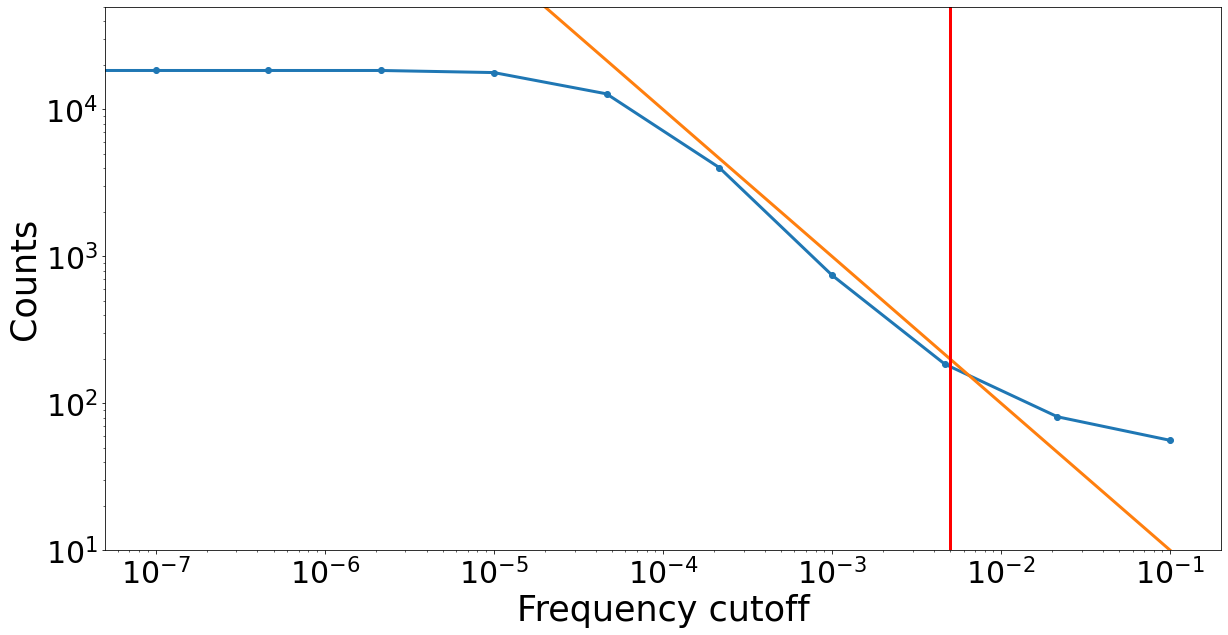

In [ ]:
xmin_vals = np.array(xmin_vals)
fig,ax= plt.subplots(1,1,figsize=(20,10))
ax.plot(xmin_vals,count_thresh,marker='o')
ax.plot(xmin_vals,1/xmin_vals)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Frequency cutoff')
ax.set_ylabel('Counts')

ax.set_ylim(bottom=1e1,top=5e4)
ax.axvline(x = 5e-3,color='r')


In [ ]:
b,h= np.histogram(x_origination_times['day_diff_0.0e+00'].dt.days,bins = np.arange(0,x_origination_times['day_diff_0.0e+00'].dt.days.max(),7))

In [ ]:
np.log(b)[~np.isinf(np.log(b))]

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([0.        , 0.        , 0.        , 0.        , 0.69314718,
       0.69314718, 1.38629436, 0.69314718, 1.79175947, 1.09861229,
       0.69314718, 1.60943791, 1.38629436, 0.        , 0.69314718,
       1.09861229, 2.07944154, 1.60943791, 1.38629436, 1.94591015,
       1.09861229, 1.38629436, 1.09861229, 1.09861229, 1.79175947,
       1.60943791, 1.38629436, 1.79175947, 1.60943791, 1.94591015,
       1.79175947, 2.19722458, 2.48490665, 2.63905733, 2.39789527,
       2.99573227, 2.7080502 , 3.09104245, 3.04452244, 2.7080502 ,
       3.04452244, 3.36729583, 3.4339872 , 3.33220451, 3.71357207,
       4.02535169, 4.11087386, 3.93182563, 3.73766962, 4.04305127,
       4.02535169, 4.38202663, 3.98898405, 3.97029191, 4.36944785,
       4.20469262, 4.21950771, 4.31748811, 4.18965474, 4.17438727,
       4.12713439, 4.18965474, 4.09434456, 4.00733319, 3.66356165,
       3.8286414 , 3.93182563, 3.8286414 , 4.11087386, 3.91202301,
       3.91202301, 3.95124372, 3.87120101, 4.26267988, 4.34380

In [ ]:
world_cases = covid_data['new_cases']
world_cases = world_cases[world_cases>0]
world_cases = world_cases[~np.isinf(world_cases)]
world_cases = world_cases[~np.isnan(world_cases)]

382751     0.693147
382758     3.806662
382765     4.499810
382772     7.547502
382779     9.436519
            ...    
384263    11.208965
384270    11.143715
384277    10.974060
384284    10.903476
384291    10.654621
Name: new_cases, Length: 221, dtype: float64

average weekly count: 98.4
average weekly cases: 3.5e+06
weekly mutation rate: 2.8e-05

geometric average weekly count: 50.3
geometric average weekly cases: 1.2e+06
geometric weekly mutation rate: 4.2e-05


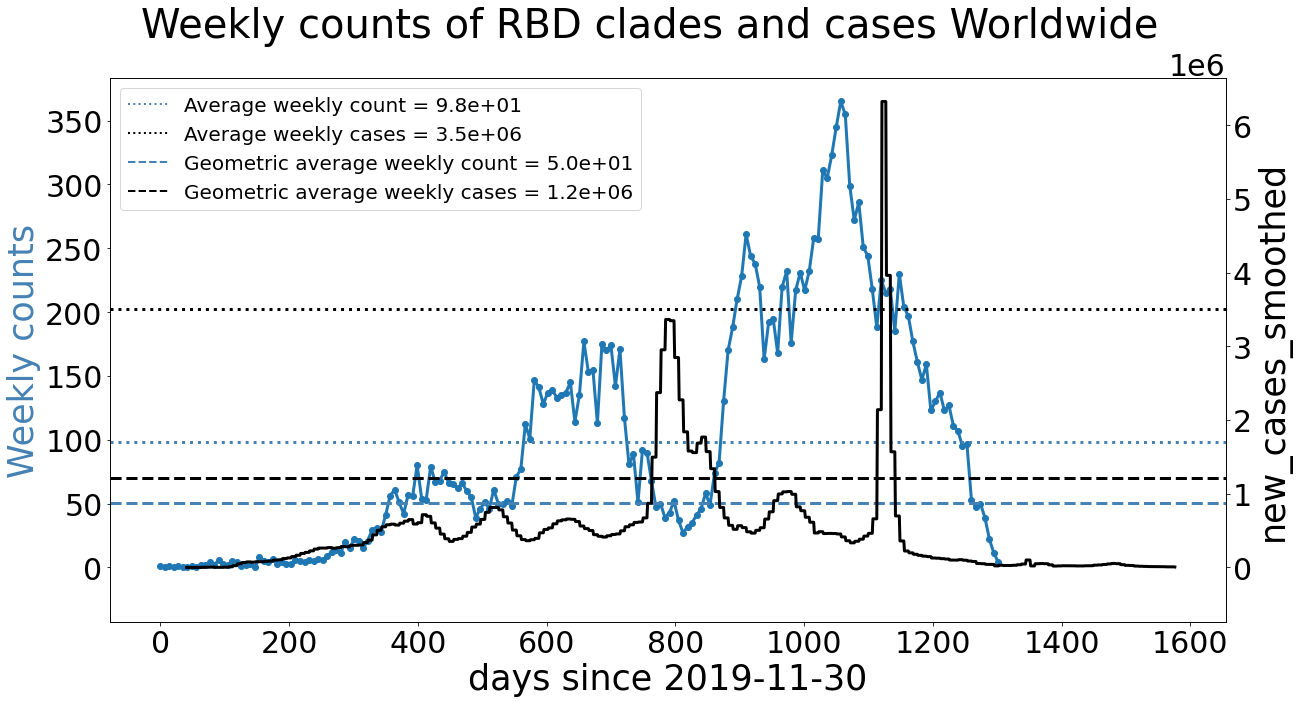

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(20,10))

ax.plot(h[:-1],b,marker='o')
geom_avg_weekly_counts = np.exp(np.average(np.log(b[b>0])))
geom_avg_weekly_cases = np.exp(np.average(np.log(world_cases)))

lin_avg_weekly_counts = np.average(b)
lin_avg_weekly_cases = np.average(world_cases)

ax.axhline(lin_avg_weekly_counts,color='steelblue',ls = ':')
ax.axhline(geom_avg_weekly_counts,color='steelblue',ls = '--')
# for xmin in xmin_vals[1:3:1]:
#     plt.hist(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = 100,histtype='step',density=True,label = f'{xmin:.1e}',lw=3);

tax= ax.twinx()
sns.lineplot(data = covid_data, x = 'day_diff', y = 'new_cases_smoothed', ax = tax ,color='black')
tax.set_xlim(ax.get_xlim())

mpl_axes_aligner.align.yaxes(ax, 0, tax, 0, 0.1)
tax.axhline(lin_avg_weekly_cases,color='black',ls = ':')
tax.axhline(geom_avg_weekly_cases,color='black',ls = '--')
print(f'average weekly count: {lin_avg_weekly_counts:.1f}')
print(f'average weekly cases: {lin_avg_weekly_cases:.1e}')
print(f'weekly mutation rate: {lin_avg_weekly_counts/lin_avg_weekly_cases:.1e}')
print()
print(f'geometric average weekly count: {geom_avg_weekly_counts:.1f}')
print(f'geometric average weekly cases: {geom_avg_weekly_cases:.1e}')
print(f'geometric weekly mutation rate: {geom_avg_weekly_counts/geom_avg_weekly_cases:.1e}')

handles = [
    Line2D([0], [0], color='steelblue', lw=2, ls = ':', label=f'Average weekly count = {lin_avg_weekly_counts:.1e}'),
    Line2D([0], [0], color='black', lw=2, ls = ':', label=f'Average weekly cases = {lin_avg_weekly_cases:.1e}'), 
    Line2D([0], [0], color='steelblue', lw=2, ls = '--', label=f'Geometric average weekly count = {geom_avg_weekly_counts:.1e}'),
    Line2D([0], [0], color='black', lw=2, ls = '--', label=f'Geometric average weekly cases = {geom_avg_weekly_cases:.1e}'),]


ax.legend(handles= handles,loc='upper left',fontsize=20)
ax.set_xlabel(f'days since {reference_date}')
ax.set_ylabel('Weekly counts',color='steelblue')
fig.suptitle('Weekly counts of RBD clades and cases Worldwide')
plt.savefig(output_folder+'/weekly_counts_worldwide.pdf',bbox_inches='tight')
# ax.set_yscale('log')

In [ ]:
xmin = 0.001
i=2
clade_statistics_SARS_CoV_2.query(f'Clade == {i} & Sublineage_Freq > {xmin}')['Time'].min()



nan

In [ ]:
covid_data['day_diff'] = covid_data['day_diff'].apply(lambda x: x.days)

In [ ]:
# !pip install mpl-axes-aligner
import mpl_axes_aligner


In [ ]:
(pd.to_datetime(omicron_origination)-origination_times['Time_datetime'].min()).days

455

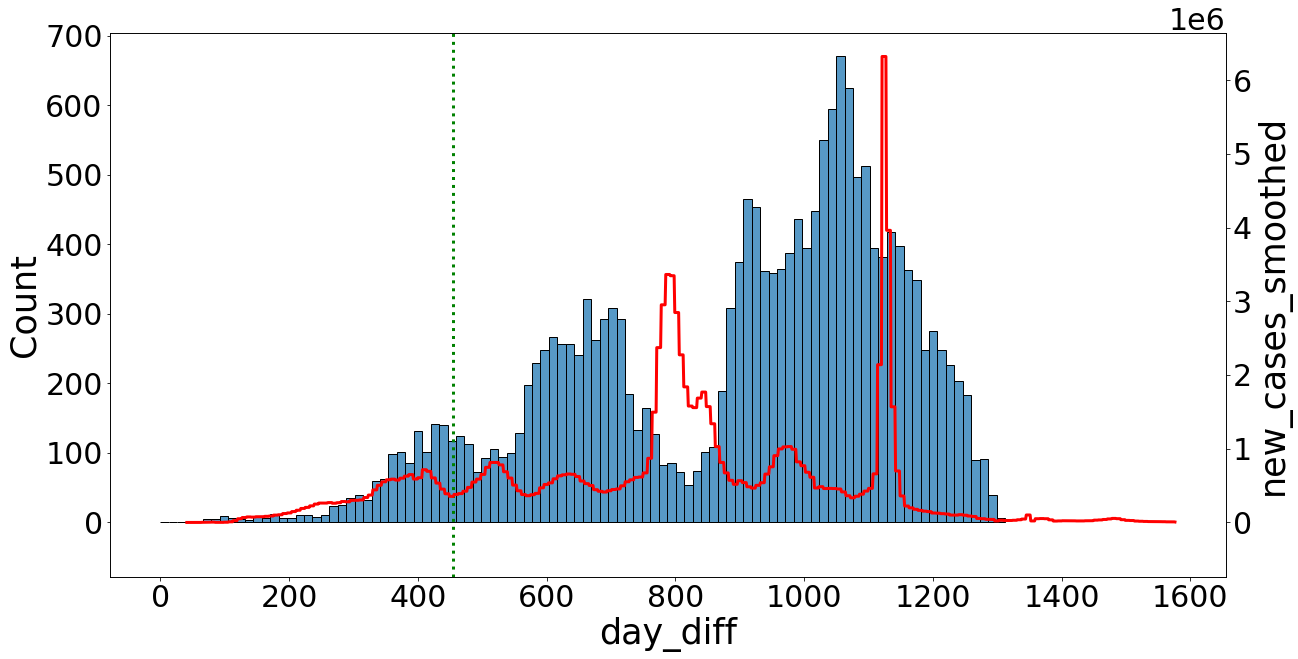

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(20,10),sharex=False)
sns.histplot(origination_times['day_diff'].dt.days,bins = 100, ax= ax)
tax = ax.twinx()
sns.lineplot(data = covid_data, x = 'day_diff', y = 'new_cases_smoothed', ax = tax ,color='red')
tax.set_xlim(ax.get_xlim())

mpl_axes_aligner.align.yaxes(ax, 0, tax, 0, 0.1)
ax.axvline((pd.to_datetime(omicron_origination)-origination_times['Time_datetime'].min()).days,color='green',ls=':')

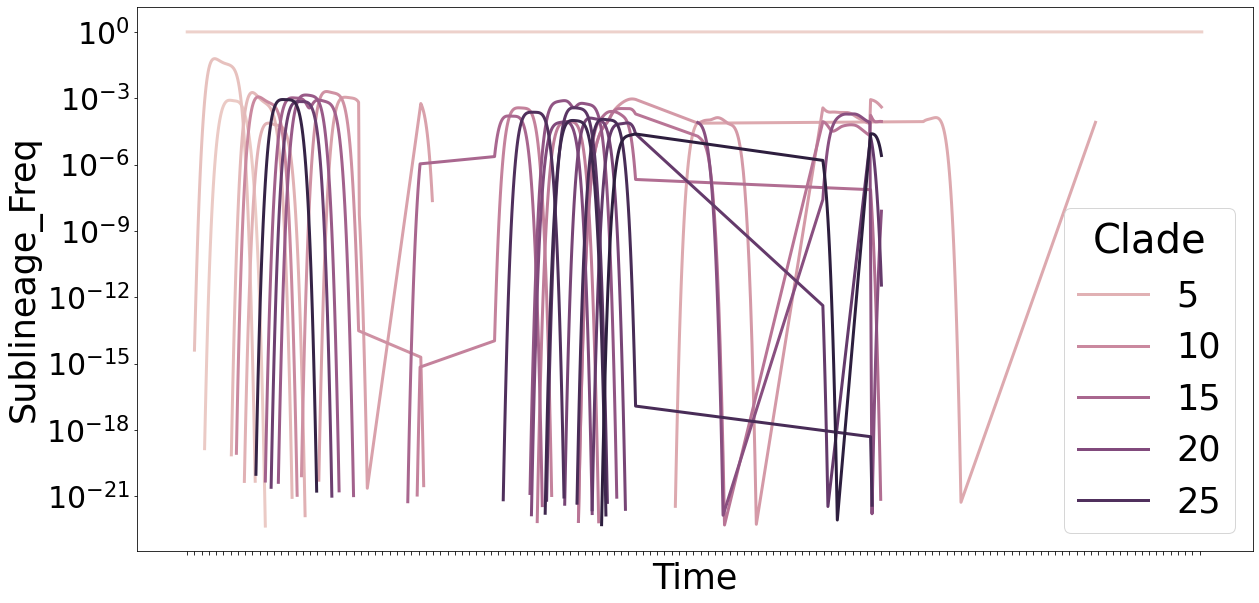

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(20,10))
 
sns.lineplot(data = clade_statistics_SARS_CoV_2.query(f'Clade<30'), x = 'Time', y='Sublineage_Freq', hue = 'Clade')


printevery_xtick = 10
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
ax.set_xticks(xticks[::printevery_xtick]);
ax.set_xticklabels(xticklabels[::printevery_xtick], rotation = 25);

ax.set_yscale('log')

In [ ]:
xticklabels

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T